## GO term training
This is a notebook trained on subset of GO aggregated file, becasue shap summary plot takes too much memory

In [1]:
# Imports
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier, Pool, cv
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.metrics import classification_report
from catboost.utils import get_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

### Load training file

In [2]:
%%time
training_data_file = '../data/removed_rows_biome_freq_is_low.pickle'
if os.path.exists(training_data_file):
    df = pd.read_pickle(training_data_file)
    null_vals = df.isnull().sum(axis=0)
    assert len(null_vals[null_vals != 0]) == 0
df_sub = df.head(10000)

CPU times: user 1.43 s, sys: 2.67 s, total: 4.1 s
Wall time: 3.95 s


### Print X

In [3]:
# Split into input and output
y = df_sub.loc[:, 'biome']
X = df_sub[df_sub.columns[4:]]
X

,exptype,GO:0043130,GO:0055074,GO:0055117,GO:0046933,GO:0006302,GO:0008643,GO:0043752,GO:0007026,GO:0005976,...,GO:0019357,GO:0006527,GO:0004114,GO:0046423,GO:0034194,GO:0032183,GO:0007618,GO:0030097,GO:0004520,GO:0033739
0,unknown,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
1,unknown,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2,unknown,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
3,unknown,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
4,unknown,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10006,assembly,0.002331,0.0,0.0,0.001691,0.003564,0.000147,0.001074,0.0,0.000076,...,0.125,0.000829,0.0,0.0,0.0,0.0,0.0,0.0,0.001067,0.000994
10007,assembly,0.002331,0.0,0.0,0.001691,0.003564,0.000147,0.001074,0.0,0.000076,...,0.125,0.000829,0.0,0.0,0.0,0.0,0.0,0.0,0.001067,0.000994
10008,assembly,0.002331,0.0,0.0,0.001691,0.003564,0.000147,0.001074,0.0,0.000076,...,0.125,0.000829,0.0,0.0,0.0,0.0,0.0,0.0,0.001067,0.000994
10009,assembly,0.002331,0.0,0.0,0.001691,0.003564,0.000147,0.001074,0.0,0.000076,...,0.125,0.000829,0.0,0.0,0.0,0.0,0.0,0.0,0.001067,0.000994


### Print y

In [4]:
y

0        root:Host-associated:Mammals:Respiratory syste...
1        root:Host-associated:Mammals:Respiratory syste...
2        root:Host-associated:Mammals:Respiratory syste...
3        root:Host-associated:Mammals:Respiratory syste...
4        root:Host-associated:Mammals:Respiratory syste...
                               ...                        
10006    root:Host-associated:Human:Digestive system:La...
10007    root:Host-associated:Human:Digestive system:La...
10008    root:Host-associated:Human:Digestive system:La...
10009    root:Host-associated:Human:Digestive system:La...
10010    root:Host-associated:Human:Digestive system:La...
Name: biome, Length: 10000, dtype: object

### Split dataset into traning and vlidation

In [5]:
# Split into train and test sets
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.75, random_state=42)

In [6]:
train_labels = set(y_train)

#### check dataset
remove rows with y lebel not in train dataset

In [7]:
drop_rows = []
for index in X_validation.index:
    if y_validation.loc[index] not in train_labels:
        drop_rows.append(index)
print(drop_rows)
X_validation = X_validation.drop(drop_rows)
y_validation = y_validation.drop(drop_rows)
print(len(X_validation))
assert len(X_validation) == len(y_validation)

[33, 31, 6830, 30]
2496


In [8]:
# Init the model
model = CatBoostClassifier(
    custom_loss=['Accuracy'],
    random_seed=42,
    task_type="GPU"
)

Initialize model

In [9]:
# Train
X_train_pool = Pool(
    data=X_train,
    label=y_train,
    cat_features=np.where(X_train.dtypes != np.float)[0],
)

Load trained model 

In [10]:
trained_model = 'GO_model_with_exptype.json'
# if os.path.exists(trained_model):
#     model.load_model(trained_model, format='json')

### Model training

In [11]:
# Train
model.fit(
    X_train_pool,
    logging_level='Verbose',
    plot=True,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.097903
0:	learn: 1.5926009	total: 157ms	remaining: 2m 36s
1:	learn: 1.2975021	total: 298ms	remaining: 2m 28s
2:	learn: 1.1531814	total: 428ms	remaining: 2m 22s
3:	learn: 1.0541495	total: 561ms	remaining: 2m 19s
4:	learn: 0.9512065	total: 688ms	remaining: 2m 16s
5:	learn: 0.8766932	total: 824ms	remaining: 2m 16s
6:	learn: 0.8170163	total: 951ms	remaining: 2m 14s
7:	learn: 0.7650802	total: 1.08s	remaining: 2m 13s
8:	learn: 0.7194037	total: 1.21s	remaining: 2m 13s
9:	learn: 0.6790846	total: 1.34s	remaining: 2m 12s
10:	learn: 0.6404973	total: 1.48s	remaining: 2m 12s
11:	learn: 0.6099885	total: 1.6s	remaining: 2m 11s
12:	learn: 0.5793360	total: 1.73s	remaining: 2m 11s
13:	learn: 0.5588452	total: 1.86s	remaining: 2m 10s
14:	learn: 0.5382914	total: 1.98s	remaining: 2m 9s
15:	learn: 0.5210361	total: 2.1s	remaining: 2m 8s
16:	learn: 0.5026829	total: 2.22s	remaining: 2m 8s
17:	learn: 0.4869150	total: 2.34s	remaining: 2m 7s
18:	learn: 0.4733144	total: 2.46s	remaining: 2m 7s

### Save model

In [12]:
# save model
model.save_model(trained_model,
           format="json",
           export_parameters=None,
           pool=X_train_pool)

### Prediction

In [13]:
predictions = model.predict(X_validation)
predictions_probs = model.predict_proba(X_validation)
matches = [x[0] == y for x, y in zip(predictions, y_validation)]
print('Correct predictions:', len([m for m in matches if m]))
print('Incorrect predictions:', len([m for m in matches if not m]))

Correct predictions: 2256
Incorrect predictions: 240


In [14]:
model.score(X_validation, y_validation)

0.9038461538461539

In [15]:
model.get_best_score()

{'learn': {'Accuracy': 0.8998666666666667, 'MultiClass': 0.200935986328125}}

### Analysis

#### precision and recall

In [16]:
precision_recall_fscore_support(y_validation, predictions, average=None)

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.


(array([1.        , 1.        , 0.        , 0.96969697, 1.        ,
        1.        , 1.        , 1.        , 0.        , 1.        ,
        0.96428571, 0.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 0.95238095, 0.        , 1.        ,
        0.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        0.86786114, 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        ]),
 array([1.       , 1.       , 0.       , 1.       , 1.       , 1.       ,
        1.       , 1.       , 0.       , 1.       , 1.       , 0.       ,
        1.       , 0.875    , 1.       , 1.       , 1.       , 1.       ,
        0.       , 1.       , 0.       , 1.       , 1.       , 1

In [17]:
precision_recall_fscore_support(y_validation, predictions, average='micro')

(0.9038461538461539, 0.9038461538461539, 0.9038461538461539, None)

In [18]:
precision_recall_fscore_support(y_validation, predictions, average='weighted')

(0.9151836565706597, 0.9038461538461539, 0.8610623716286637, None)

In [19]:
precision_recall_fscore_support(y_validation, predictions, average=None, labels=model.classes_)

(array([1.        , 0.        , 1.        , 0.        , 0.96969697,
        1.        , 1.        , 0.        , 1.        , 1.        ,
        0.        , 1.        , 0.96428571, 0.        , 0.        ,
        1.        , 0.        , 1.        , 1.        , 0.        ,
        1.        , 0.        , 1.        , 0.        , 0.95238095,
        0.        , 1.        , 0.        , 1.        , 1.        ,
        0.        , 1.        , 1.        , 0.        , 0.        ,
        0.        , 1.        , 1.        , 0.        , 1.        ,
        1.        , 1.        , 0.        , 1.        , 0.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 0.86786114,
        1.        , 1.        , 0.        , 1.        , 1.        ,
        0.        , 1.        , 1.        , 0.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 0.        ,
        0.        ]),
 array([1.       , 0.     

#### Feature importance

In [20]:
model_feature_importance = pd.Series(data=model.feature_importances_, index=model.feature_names_)
model_feature_importance

exptype       23.061892
GO:0043130     0.000073
GO:0055074     0.000000
GO:0055117     0.000000
GO:0046933     0.000000
                ...    
GO:0032183     0.000000
GO:0007618     0.000000
GO:0030097     0.000000
GO:0004520     0.000000
GO:0033739     0.000000
Length: 4420, dtype: float64

GO:0004800     0.000000
GO:0004370     0.000000
GO:0000977     0.000000
GO:0042803     0.000000
GO:0046929     0.000000
                ...    
GO:0004867     2.534491
GO:0009611     3.002769
GO:0005451    13.548047
GO:0004557    19.590758
exptype       23.061892
Length: 4420, dtype: float64


Text(0.5, 0, 'CatBoost Feature Importance')

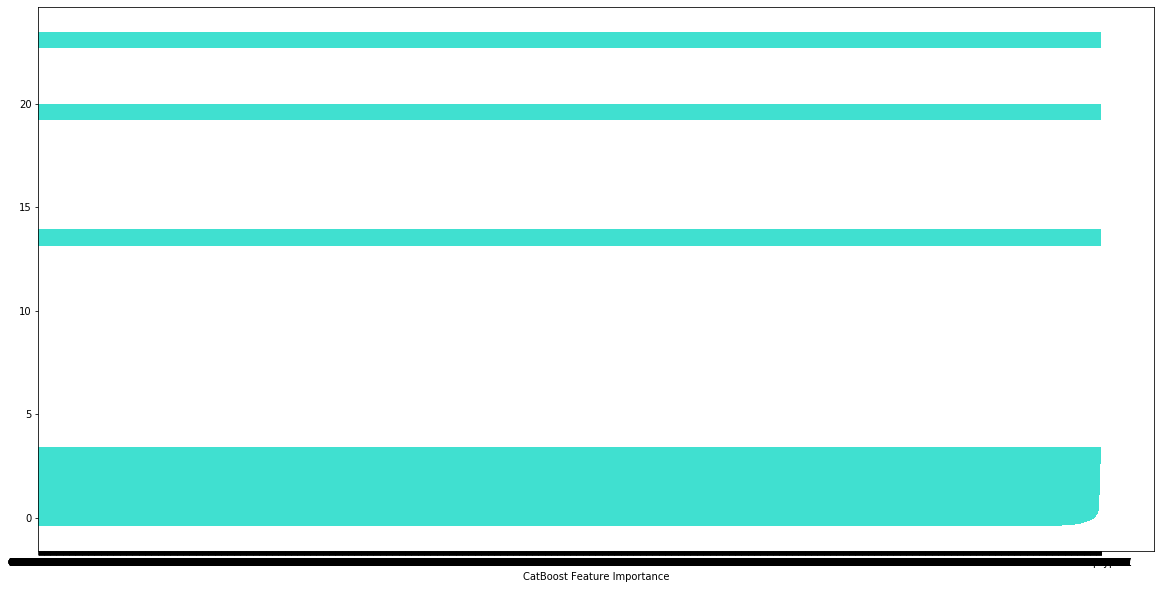

In [21]:
sorted_feature_importance = model_feature_importance[model_feature_importance.argsort()]
print(sorted_feature_importance)
plt.figure(figsize=(20,10))
plt.barh(sorted_feature_importance.values,
        sorted_feature_importance.index,
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

In [22]:
sorted_feature_importance.values

array([ 0.        ,  0.        ,  0.        , ..., 13.54804683,
       19.59075812, 23.06189242])

#### Confusion matrix

In [23]:
for label in y_validation:
    if label not in train_labels:
        idx = y_validation[y_validation == label]
        print(idx, label)

In [24]:
confusion_matrix_test = get_confusion_matrix(model, Pool(X_validation, y_validation, cat_features=np.where(X_validation.dtypes != np.float)[0]))
print(confusion_matrix_test.shape)
print(len(model.classes_))
confusion_matrix_test_pd = pd.DataFrame(data=np.log(confusion_matrix_test+0.001), columns=model.classes_, index=model.classes_)

(71, 71)
71


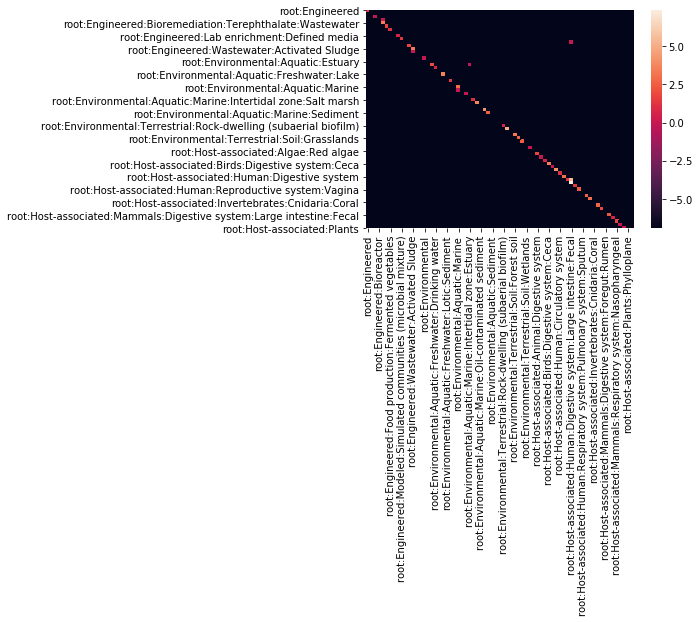

In [25]:
ax = sns.heatmap(confusion_matrix_test_pd)

#### Shap summary

In [26]:
explainer_model = shap.TreeExplainer(model)

In [27]:
shap_values = explainer_model.shap_values(X_validation)

CPU times: user 29.1 s, sys: 22.2 s, total: 51.3 s
Wall time: 2min 19s


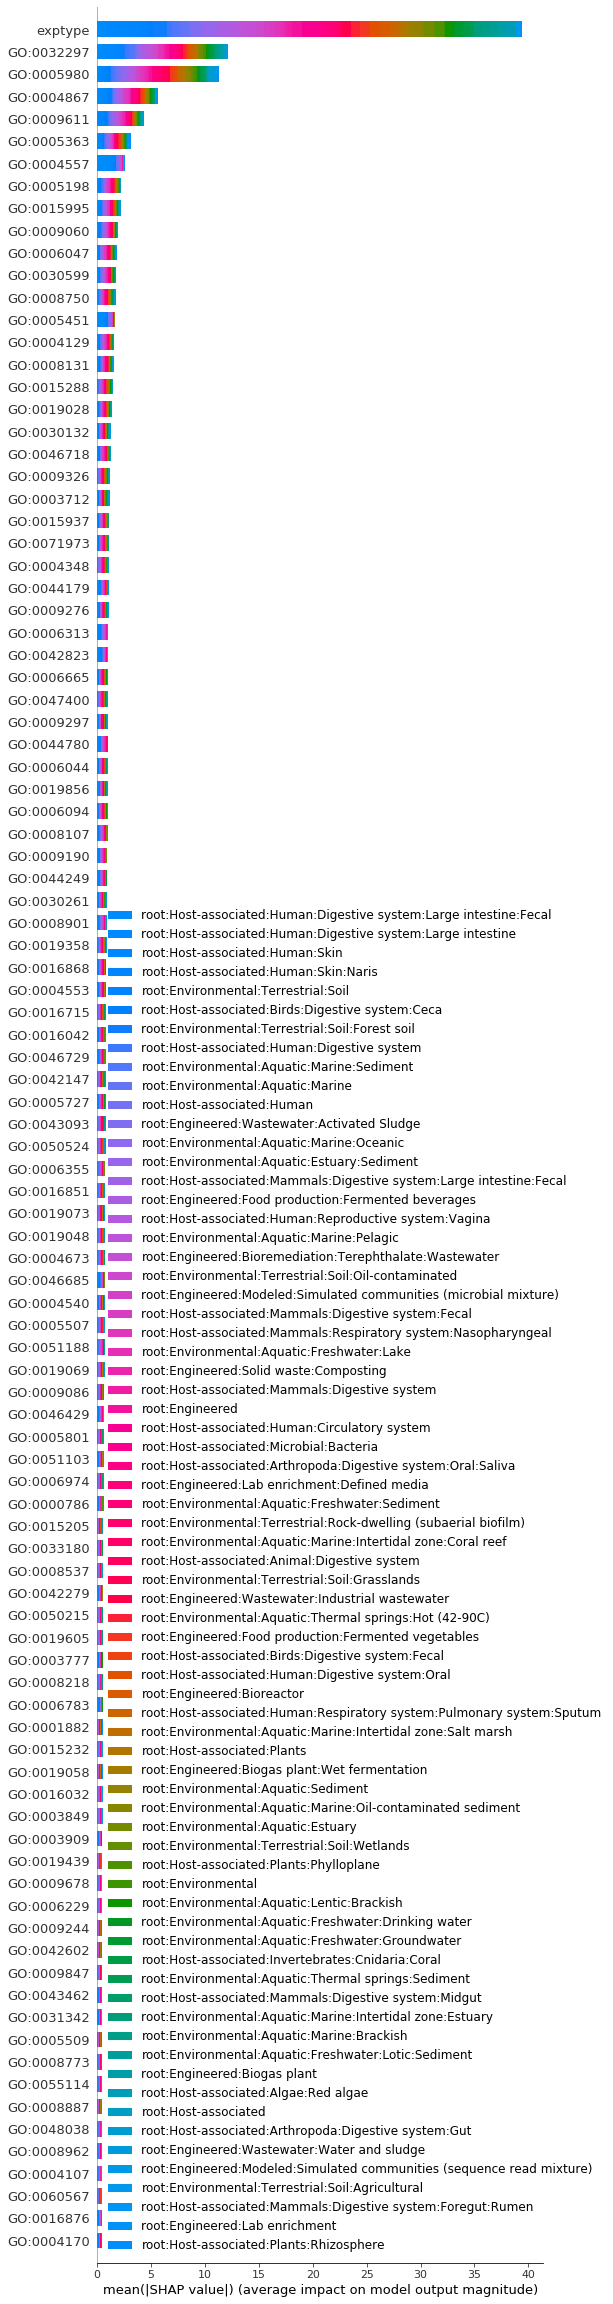

In [28]:
%%time
shap.summary_plot(shap_values, X_validation, feature_names = X_validation.columns, max_display=100, class_names=model.classes_,show=False)
f = plt.gcf()
plt.savefig('shap_summary_first_100_with_exptype.png',bbox_inches='tight')